# Life-Cycle Labor Supply of Couples with Children

Solves and simulates a $T$-period labor supply model with two-earner couples. <br>
**Motivated** by the study “Child-Related Transfers, Household Labor Supply and Welfare” by [Guner et al. (2020)](https://academic.oup.com/restud/article/87/5/2290/5809564). <br>
**Goal** is to replicate effects of child-related transfers.

For simplicity, couples cannot divorce nor save.

The **Bellman equation** and the recursive formulation of our simple model is 
$$
\begin{align*}
V_{t}(n_{t},K_{1,t},K_{2,t}) & =\max_{h_{1,t},h_{2,t}}U(c_{t},h_{1,t},h_{2,t},n_{t})\\
 & \qquad\qquad+\beta\mathbb{E}_{t}[V_{t+1}(n_{t+1},K_{1,t+1},K_{2,t+1})]\\
c_{t} & =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t},w_{2,t}h_{2,t})\\
 & \qquad+\mathcal{C}(n_{t},h_{1,t},h_{2,t},w_{1,t},w_{2,t})\\
n_{t+1} & =\begin{cases}
\begin{array}{ll}
n_t + 1 & \text{with prob. } p(n_{t})\\
n_t & \text{with prob. } 1-p(n_{t})
\end{array}\end{cases}\\
\log w_{j,t} & =\alpha_{j,0}+\alpha_{j,1}K_{j,t},\;j\in\{1,2\}\\
K_{j,t+1} & =(1-\delta)K_{j,t}+h_{j,t},\;j\in\{1,2\}
\end{align*}
$$
where 
$$
p(n_t) = \begin{cases}
\begin{array}{ll}
p_n & \text{if } n_{t}=0\\
0 &  \text{if } n_{t}=1.
\end{array}\end{cases}
$$

**Child-related transfers:** We assume that if both work, they have to buy childcare. <br>
This means that conditional transfers are always a subsidy (cannot do 5 or 6 in taxonomy of Guner et al. (2020)). <br>
Child-related transfers are
$$
\begin{align*}
\mathcal{C}(n_{t},h_{1,t},h_{2,t},w_{1,t},w_{2,t}) & =\mathcal{C}_{1}(n_{t})+\mathcal{C}_{2}(n_{t},Y_{t})\\
 & +[\mathcal{C}_{3}(n_{t})+\mathcal{C}_{4}(n_{t},Y_{t})]\cdot\mathbf{1}(h_{1,t}\cdot h_{2,t}>0)
\end{align*}
$$
where household income is
$$
Y_{t}=\sum_{j=1}^{2}w_{j,t}h_{j,t}.
$$

The code could look something like
```python
def child_tran(self,hours1,hours2,income_hh,kids):
    par = self.par
    if kids<1:
        return 0.0
    
    else:
        C1 = par.uncon_uni                           #unconditional, universal transfer (>0)
        C2 = np.fmax(par.means_level - par.means_slope*income_hh , 0.0) #means-tested transfer (>0)
        # child-care related (net-of-subsidy costs)
        both_work = (hours1>0) * (hours2>0)
        C3 = par.cond*both_work                      #all working couples has this net cost (<0)
        C4 = par.cond_high*both_work*(income_hh>0.5) #low-income couples do not have this net-cost (<0)

    return C1+C2+C3+C4
```

**Preferences** are sum of individuals
$$
U(c_{t},h_{1,t},h_{2,t})=2\frac{(c_{t}/2)^{1+\eta}}{1+\eta}-\rho_{1}(n_{t})\frac{h_{1,t}^{1+\gamma}}{1+\gamma}-\rho_{2}(n_{t})\frac{h_{2,t}^{1+\gamma}}{1+\gamma}
$$
with 
$$
\rho_{j}(n_{t})=\rho_{0,j}+\rho_{1,j}n_{t}
$$

**Taxes** are on the household level and child-related transfers/costs are included in taxable income
$$
T(\tilde{Y})=(1-\lambda(\tilde{Y})^{-\tau})\cdot(\tilde{Y})
$$
where $\tilde{Y} = Y + \mathcal{C}(n_{t},h_{1,t},h_{2,t},w_{1,t},w_{2,t})$.

**Expected value** is
$$
\begin{align*}
\mathbb{E}_{t}[V_{t+1}(n_{t+1},K_{1,t+1},K_{2,t+1})] & =p(n_{t})V_{t+1}(n_{t}+1,K_{1,t+1},K_{2,t+1})\\
 & +(1-p(n_{t}))V_{t+1}(n_{t},K_{1,t+1},K_{2,t+1})
\end{align*}
$$

**Terminal period:** There are no bequests such that
$$
V_{T}(n_T,K_{1,T},K_{2,T})  =\max_{h_{1,T},h_{2,T}}U(c_{T},h_{1,T},h_{2,T})
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Dual-Earner Model with Children

In [2]:
# load local model file and initialize model class
from DynHouseholdLaborModel import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim

In [3]:
%time model.solve()

t: 9


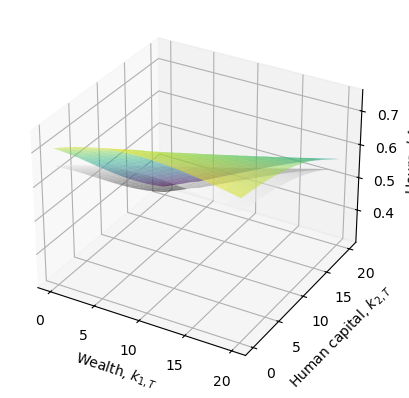

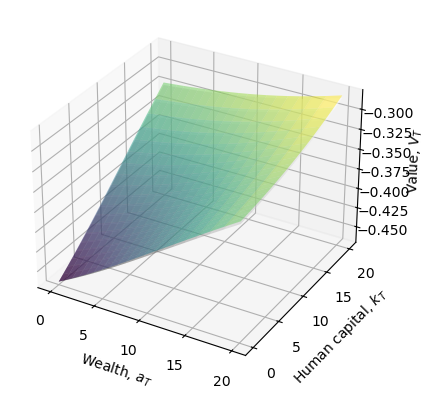

In [5]:
k1_mesh,k2_mesh = np.meshgrid(par.k_grid,par.k_grid,indexing='ij')

# first period
t = 0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(k1_mesh, k2_mesh, sol.h1[t,0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.5);
ax.plot_surface(k1_mesh, k2_mesh, sol.h1[t,1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.5);
ax.set(xlabel='Wealth, $k_{1,T}$',ylabel='Human capital, $k_{2,T}$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(k1_mesh, k2_mesh, sol.V[t,0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.5);
ax.plot_surface(k1_mesh, k2_mesh, sol.V[t,1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.5);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Value, $V_{T}$');

# Simulate child-related transfers reforms

In [6]:
model.simulate()

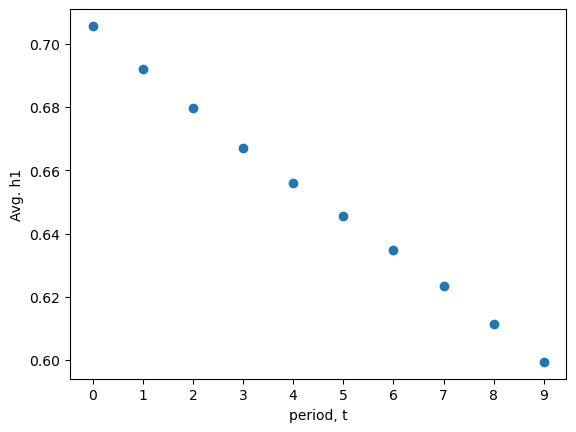

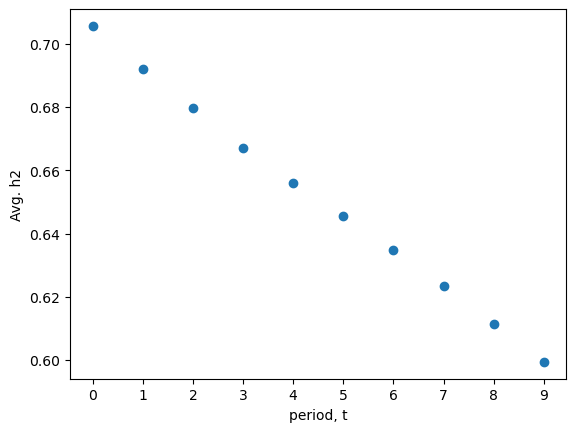

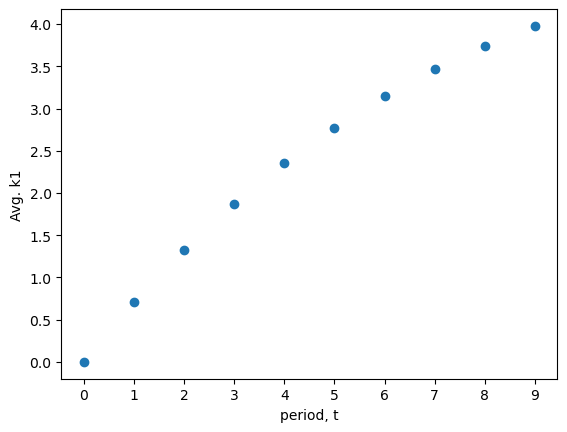

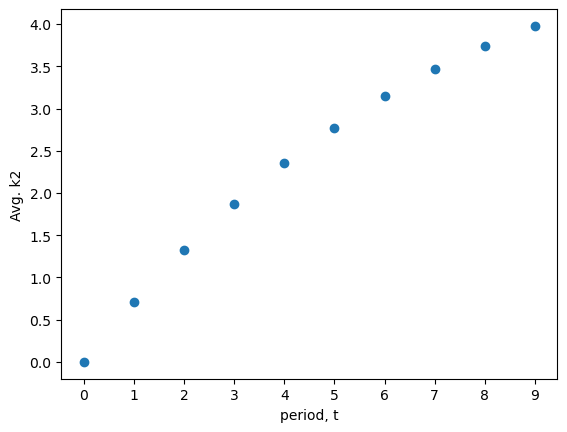

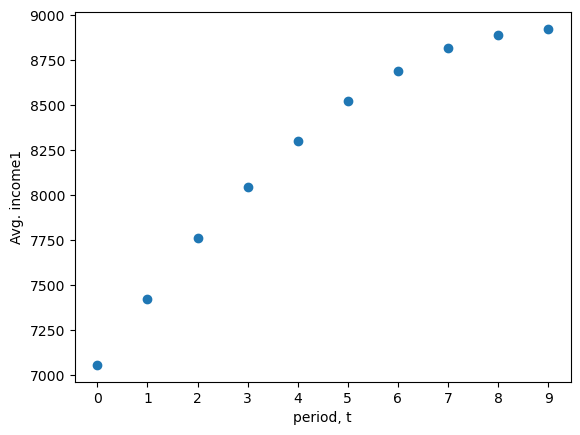

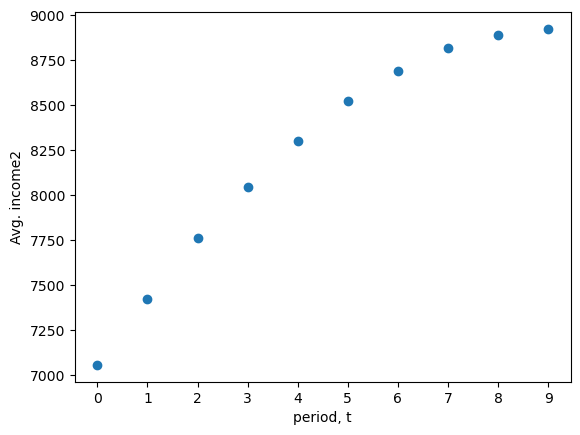

In [7]:
# plot behavior
for var in ('h1','h2','k1','k2','income1','income2'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(sim,var),axis=0),label='Simulated')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));

In [31]:
model_no_transfers = DynHouseholdLaborModelClass(par={'uncon_uni': 0.0, 'means_level': 0.0, 'means_slope': 0.0, 'cond':0.0, 'cond_high': 0.0})
model_uncon_uni = DynHouseholdLaborModelClass(par={'uncon_uni': 1000.0, 'means_level': 0.0, 'means_slope': 0.0, 'cond':0.0, 'cond_high': 0.0})
model_uncon_means = DynHouseholdLaborModelClass(par={'uncon_uni': 0.0, 'means_level': 1000.0, 'means_slope': 25.0, 'cond':0.0, 'cond_high': 0.0})
model_con_uni = DynHouseholdLaborModelClass(par={'uncon_uni': 0.0, 'means_level': 0.0, 'means_slope': 0.0, 'cond':1000.0, 'cond_high': 0.0})
model_con_means = DynHouseholdLaborModelClass(par={'uncon_uni': 0.0, 'means_level': 0.0, 'means_slope': 0.0, 'cond':1000.0, 'cond_high': -500.0})

In [32]:
model_no_transfers.solve()
model_no_transfers.simulate()

model_uncon_uni.solve()
model_uncon_uni.simulate()

model_uncon_means.solve()
model_uncon_means.simulate()

model_con_uni.solve()
model_con_uni.simulate()

model_con_means.solve()
model_con_means.simulate()


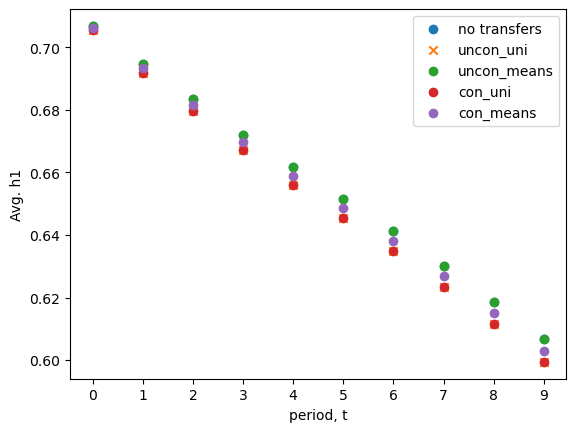

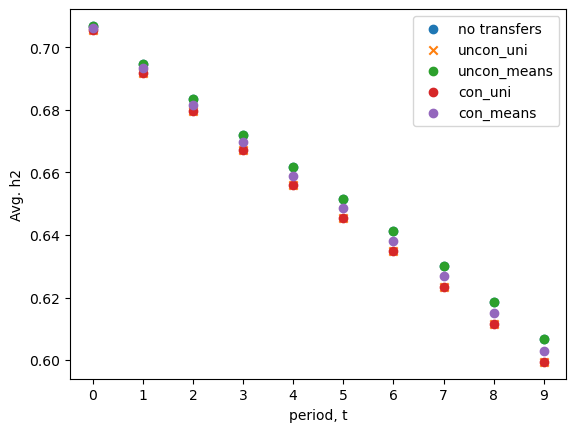

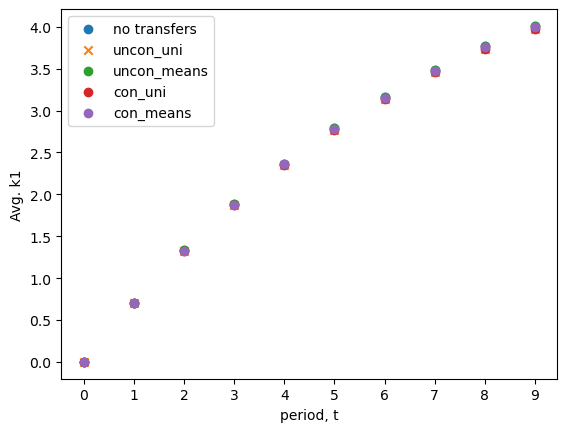

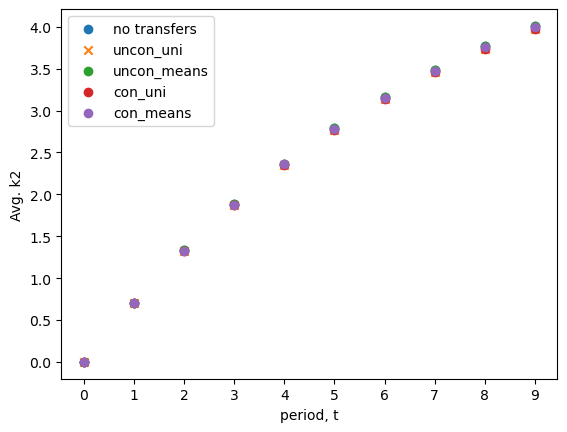

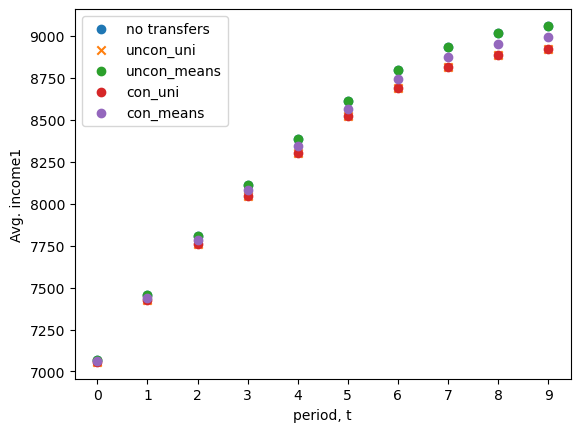

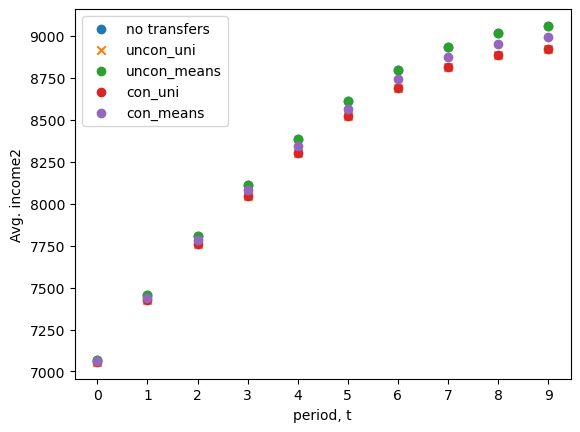

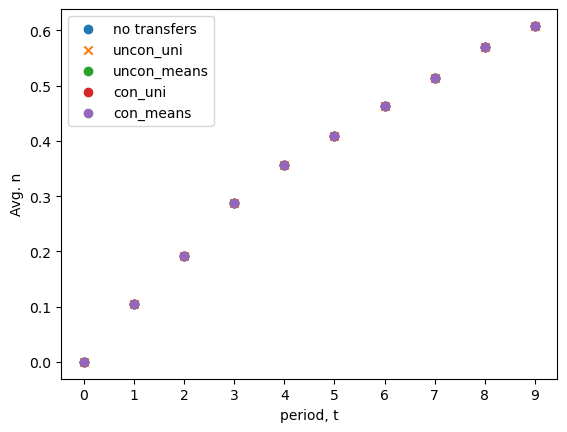

In [33]:


# plot behavior
for var in ('h1','h2','k1','k2','income1','income2', 'n'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(model_no_transfers.sim,var),axis=0),label='no transfers')
    ax.scatter(range(par.simT),np.mean(getattr(model_uncon_uni.sim,var),axis=0),label='uncon_uni', marker = 'x')
    ax.scatter(range(par.simT),np.mean(getattr(model_uncon_means.sim,var),axis=0),label='uncon_means')
    ax.scatter(range(par.simT),np.mean(getattr(model_con_uni.sim,var),axis=0),label='con_uni')
    ax.scatter(range(par.simT),np.mean(getattr(model_con_means.sim,var),axis=0),label='con_means')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();